# G-Research Crypto Forecast

## Part 0: Introduction

* ### Описание:

#### Ежедневно на рынке криптовалют проводятся операции на сумму более 40 миллиардов долларов. Криптовалюты являются одними из самых популярных активов как для спекуляций, так и для инвестиций. При этом рынок криптовалят является достаточно волатильным. Датасет содержит информацию о прошлых сделках по криптовалютам. Например, таких Bitcoin и Ethereum. 
#### Задача - предсказать будущую прибыль криптовалют.

* ### Датасеты:

1. train.csv - обучающий датасет

    * timestamp - отметка времени в минутах в формате Unix. Отметки времени в этом наборе данных кратны 60, что указывает на поминутные данные
    * Asset_ID - ID криптовалюты
    * Count - общее количество сделок, состоявшихся в данную минуту
    * Open - стомиость криптовалюты в начале минуты, долларах США
    * High - самая высокая стоимость криптовалюты за минуту, доллар США
    * Low - самая низкая стоимость криптовалюты цена за минуту, доллар США
    * Volume - количество единиц криптовалюты, проданных или купленных в течение минуты
    * VWAP - средневзвешенная стоимость криптовалюты за минуту, доллар США
    * Target - остаточная логарифмическая доходность актива на горизонте 15 минут


2. asset_details.csv - датасет с дополнительной информацией

    * Asset_ID - ID криптовалюты
    * Weight - вес каждого актива, используемый для взвешивания его относительной важности в метрике оценки
    * Asset_Name - название криптовалюты
   
## [Part 1: Import, Load Data](#Part-1:-Import,-Load-Data)
* ### Импорт библиотек, чтение '.csv' файлов

## [Part 2: Exploratory Data Analysis](#Part-2:-Exploratory-Data-Analysis)
* ### Head, Info
* ### Обработка датасета asset_details
* ### Добавление названия криптовалюты в обучающий датасет
* ### Анализ недостающих элементов в Target
* ### Удаление строк с недостающими элементами в Target
* ### Визуализация данных

## [Part 3: Data Wrangling and Transformation](#Part-3:-Data-Wrangling-and-Transformation)
* ### StandardScaler
* ### Создание датасетов для машинного обучения
* ### 'Train\Valid' split


## [Part 4: Machine Learning](#Part-4:-Machine-Learning)
* ### Linear Regression


## Part 1: Import, Load Data

* ### Import 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

* ### Load Data 

In [3]:
#загрузим первые 100 тысяч строк
df = pd.read_csv("train.csv", nrows=100000)

In [4]:
asset_details = pd.read_csv("asset_details.csv") 

## Part 2: Exploratory-Data-Analysis

* ### Head

In [5]:
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


* ### Info 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  100000 non-null  int64  
 1   Asset_ID   100000 non-null  int64  
 2   Count      100000 non-null  float64
 3   Open       100000 non-null  float64
 4   High       100000 non-null  float64
 5   Low        100000 non-null  float64
 6   Close      100000 non-null  float64
 7   Volume     100000 non-null  float64
 8   VWAP       100000 non-null  float64
 9   Target     97604 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 7.6 MB


Есть пропущенные значения в колонке Target. Их нужно будет заполнить

In [8]:
df["Target"].describe()

count    97604.000000
mean         0.000271
std          0.010470
min         -0.099856
25%         -0.004165
50%          0.000000
75%          0.004304
max          0.129324
Name: Target, dtype: float64

<AxesSubplot:xlabel='Target', ylabel='Count'>

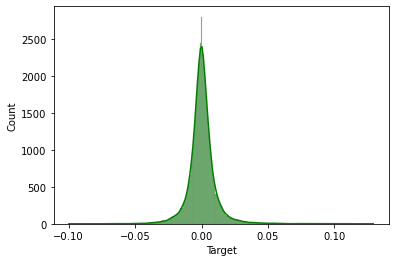

In [9]:
sns.histplot(df['Target'], color='g', kde=True)

Распределение значений Target близко к нормальному

* ### Обработка датасета asset_details

Зададим ID криптовалюты как индекс данного датасета

In [10]:
asset_details.set_index("Asset_ID", inplace=True)

In [11]:
asset_details

,Weight,Asset_Name
Asset_ID,,
2,2.397895,Bitcoin Cash
0,4.304065,Binance Coin
1,6.779922,Bitcoin
5,1.386294,EOS.IO
7,2.079442,Ethereum Classic
6,5.894403,Ethereum
9,2.397895,Litecoin
11,1.609438,Monero
13,1.791759,TRON


* ### Добавление названия криптовалюты в обучающий датасет

In [12]:
df["Name"] = df["Asset_ID"].apply(lambda x: asset_details.loc[x][-1])

In [13]:
df = df.set_index("Name").reset_index()

In [14]:
df.head()

,Name,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,Bitcoin Cash,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,Binance Coin,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,Bitcoin,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,EOS.IO,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,Ethereum Classic,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


* ### Анализ недостающих элементов в Target

In [15]:
#Посмотрим, какие криптовалюты и сколько не имеют Target
df[df["Target"].isnull()]["Name"].value_counts()

Monero              1221
EOS.IO               796
Ethereum Classic     215
Binance Coin         164
Name: Name, dtype: int64

In [16]:
null_names = dict(df[df["Target"].isnull()]["Name"].value_counts())
for name, count in null_names.items():
    name_full_count = df[df["Name"] == name]["Name"].value_counts()[-1]
    print(f"Количество NAN у криптовалюты {name}: {count} из {name_full_count}")
    print(f"В процентном соотношении: {round(count / name_full_count * 100, 2)}%")
    print()

Количество NAN у криптовалюты Monero: 1221 из 11947
В процентном соотношении: 10.22%

Количество NAN у криптовалюты EOS.IO: 796 из 12230
В процентном соотношении: 6.51%

Количество NAN у криптовалюты Ethereum Classic: 215 из 12579
В процентном соотношении: 1.71%

Количество NAN у криптовалюты Binance Coin: 164 из 12485
В процентном соотношении: 1.31%



* ### Удаление строк с недостающими элементами в Target

In [17]:
df_without_null = df.drop(df[df["Target"].isnull()]["Name"].keys(), axis=0)

In [18]:
df_without_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97604 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       97604 non-null  object 
 1   timestamp  97604 non-null  int64  
 2   Asset_ID   97604 non-null  int64  
 3   Count      97604 non-null  float64
 4   Open       97604 non-null  float64
 5   High       97604 non-null  float64
 6   Low        97604 non-null  float64
 7   Close      97604 non-null  float64
 8   Volume     97604 non-null  float64
 9   VWAP       97604 non-null  float64
 10  Target     97604 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 8.9+ MB


In [19]:
df_without_null.head(10)

,Name,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,Bitcoin Cash,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,Binance Coin,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,Bitcoin,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,EOS.IO,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,Ethereum Classic,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,Ethereum,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,Litecoin,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
8,Bitcoin Cash,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,Binance Coin,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875
10,Bitcoin,1514764920,1,235.0,13835.036000,14052.3000,13680.0000,13828.102000,31.046432,13840.362591,-0.015037


* ### Визуализация данных

<AxesSubplot:xlabel='timestamp', ylabel='Open'>

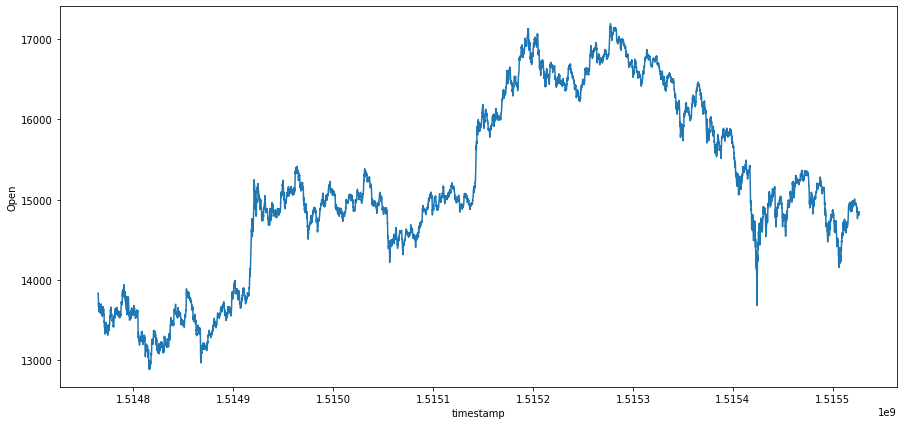

In [20]:
#Например, график цены Bitcoin на открытии
plt.figure(figsize=(15, 7))
sns.lineplot(x=df[df["Name"] == "Bitcoin"]["timestamp"], y=df[df["Name"] == "Bitcoin"]["Open"])

<AxesSubplot:xlabel='timestamp', ylabel='Open'>

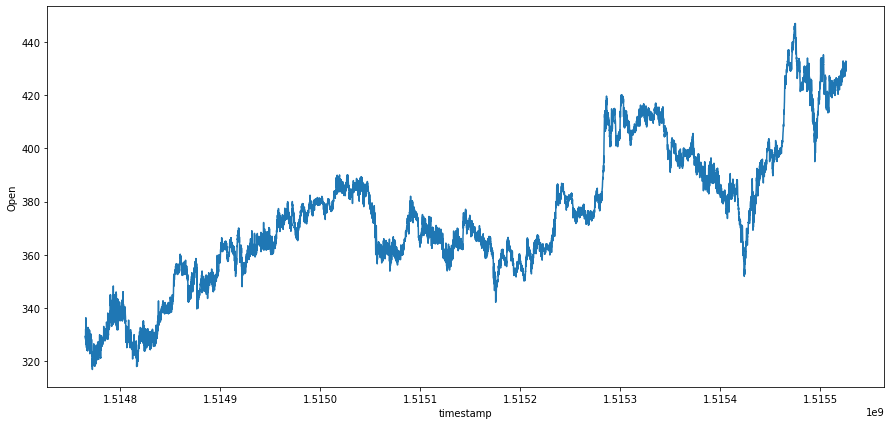

In [21]:
#Например, график цены Monero на открытии
plt.figure(figsize=(15, 7))
sns.lineplot(x=df[df["Name"] == "Monero"]["timestamp"], y=df[df["Name"] == "Monero"]["Open"])

Посмотрим график кореляции

<AxesSubplot:>

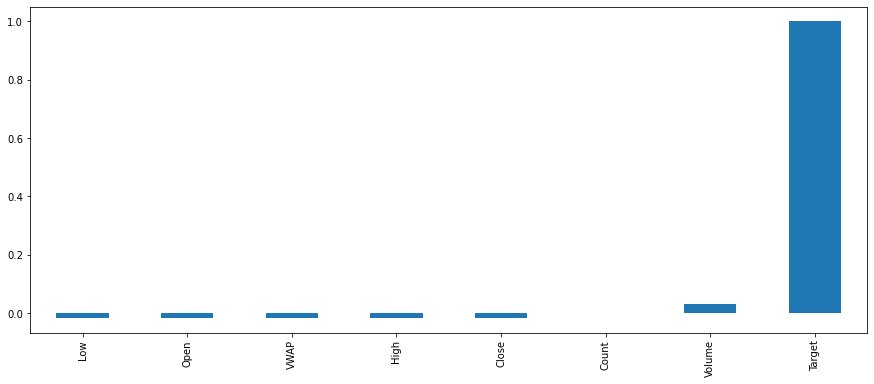

In [22]:
#Посмотрим, какие фичи коррелируют с Target
df_without_null.drop(["timestamp", "Asset_ID"], axis=1).corr()["Target"].sort_values().plot(kind="bar", figsize=(15, 6))

## Part 3: Data Wrangling and Transformation

* ### Bitcoin dataset

In [23]:
btc = df_without_null[df_without_null["Name"] == "Bitcoin"]

In [24]:
btc

,Name,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,Bitcoin,1514764860,1,229.0,13835.194000,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,Bitcoin,1514764920,1,235.0,13835.036000,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,Bitcoin,1514764980,1,528.0,13823.900000,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,Bitcoin,1514765040,1,435.0,13802.512000,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,Bitcoin,1514765100,1,742.0,13766.000000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...,...,...
99965,Bitcoin,1515525960,1,314.0,14814.546000,14904.2,14766.50,14836.802,60.239374,14832.828157,-0.003728
99973,Bitcoin,1515526020,1,251.0,14849.204000,14900.0,14748.85,14817.212,35.548938,14838.272661,-0.003222
99981,Bitcoin,1515526080,1,252.0,14827.688000,14899.9,14733.01,14818.494,27.565916,14812.488310,-0.003520
99988,Bitcoin,1515526140,1,213.0,14825.718479,14897.8,14701.00,14828.360,28.433972,14820.262771,-0.003498


* ### StandardScaler

In [25]:
features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns

In [26]:
features

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP'], dtype='object')

In [27]:
sc = StandardScaler()
df_without_null_scaled = sc.fit_transform(df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))

In [28]:
df_without_null_scaled = pd.DataFrame(df_without_null_scaled, columns=features)

In [29]:
df_without_null_scaled["Target"] = list(df_without_null["Target"])

In [30]:
df_without_null_scaled

,Open,High,Low,Close,Volume,VWAP,Target
0,-0.024067,-0.022942,-0.024679,-0.024478,-0.283093,-0.024759,-0.004218
1,-0.500484,-0.500412,-0.500508,-0.500482,-0.260371,-0.500483,-0.014399
2,2.281239,2.296402,2.266521,2.284183,-0.278361,2.279630,-0.014643
3,-0.500659,-0.500586,-0.500685,-0.500658,2.255234,-0.500659,-0.013922
4,-0.496986,-0.496939,-0.496994,-0.496992,-0.243965,-0.496990,-0.008264
...,...,...,...,...,...,...,...
97599,-0.498688,-0.498613,-0.498699,-0.498672,-0.267685,-0.498678,-0.002602
97600,2.483343,2.472935,2.485137,2.481164,-0.283053,2.481570,-0.002134
97601,-0.500328,-0.500257,-0.500350,-0.500326,-0.265686,-0.500327,-0.005362
97602,-0.495307,-0.495272,-0.495307,-0.495318,-0.175423,-0.495306,0.001431


In [31]:
df_without_null_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97604 entries, 0 to 97603
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    97604 non-null  float64
 1   High    97604 non-null  float64
 2   Low     97604 non-null  float64
 3   Close   97604 non-null  float64
 4   Volume  97604 non-null  float64
 5   VWAP    97604 non-null  float64
 6   Target  97604 non-null  float64
dtypes: float64(7)
memory usage: 5.2 MB


Проделаем тоже самое с датасетом Bitcoin

In [32]:
btc_scaled = sc.fit_transform(btc.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))

In [33]:
btc_scaled = pd.DataFrame(btc_scaled, columns=features)

In [34]:
btc_scaled["Target"] = list(btc["Target"])

In [35]:
btc_scaled

,Open,High,Low,Close,Volume,VWAP,Target
0,-1.193685,-1.174337,-1.228620,-1.180613,-0.636867,-1.200975,-0.014643
1,-1.193829,-1.138278,-1.216226,-1.200637,-0.647984,-1.188911,-0.015037
2,-1.203929,-1.186888,-1.286717,-1.224938,-0.117867,-1.220018,-0.010309
3,-1.223329,-1.188199,-1.308775,-1.255123,-0.477261,-1.240400,-0.008999
4,-1.256446,-1.228567,-1.328263,-1.294244,1.061768,-1.283949,-0.008079
...,...,...,...,...,...,...,...
12685,-0.305383,-0.340379,-0.246745,-0.285596,-0.003577,-0.288682,-0.003728
12686,-0.273947,-0.344313,-0.262494,-0.303367,-0.548596,-0.283743,-0.003222
12687,-0.293462,-0.344406,-0.276628,-0.302204,-0.724813,-0.307131,-0.003520
12688,-0.295249,-0.346373,-0.305190,-0.293254,-0.705652,-0.300080,-0.003498


* ### Создание датасетов для машинного обучения

In [36]:
X = df_without_null_scaled.drop("Target", axis=1)

In [37]:
X.head()

,Open,High,Low,Close,Volume,VWAP
0,-0.024067,-0.022942,-0.024679,-0.024478,-0.283093,-0.024759
1,-0.500484,-0.500412,-0.500508,-0.500482,-0.260371,-0.500483
2,2.281239,2.296402,2.266521,2.284183,-0.278361,2.279630
3,-0.500659,-0.500586,-0.500685,-0.500658,2.255234,-0.500659
4,-0.496986,-0.496939,-0.496994,-0.496992,-0.243965,-0.496990


In [38]:
y = df_without_null_scaled["Target"]

In [39]:
y.head()

0   -0.004218
1   -0.014399
2   -0.014643
3   -0.013922
4   -0.008264
Name: Target, dtype: float64

In [40]:
X_btc = btc_scaled.drop("Target", axis=1)

In [41]:
y_btc = btc["Target"]

* ### 'Train\Valid' split

Возьмем первые 80% данных в качестве обучающих. Остальные 20% данных в качестве валидационных

In [42]:
X.shape

(97604, 6)

In [43]:
X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(X.shape[0] * 0.8)]

In [44]:
X_train.shape, y_train.shape

((78083, 6), (78083,))

In [45]:
X_valid, y_valid = X[int(X.shape[0] * 0.8):], y[int(X.shape[0] * 0.8):]

In [46]:
X_valid.shape, y_valid.shape

((19521, 6), (19521,))

Проделаем тоже самое с датасетом Bitcoin

In [47]:
X_btc_train, y_btc_train = X_btc[:int(X_btc.shape[0] * 0.8)], y_btc[:int(X_btc.shape[0] * 0.8)]
X_btc_train.shape, y_btc_train.shape

((10152, 6), (10152,))

In [48]:
X_btc_valid, y_btc_valid = X_btc[int(X_btc.shape[0] * 0.8):], y_btc[int(X_btc.shape[0] * 0.8):]
X_btc_valid.shape, y_btc_valid.shape

((2538, 6), (2538,))

## Part 4: Machine Learning

* ### Linear Regression

In [49]:
LR = LinearRegression()

In [50]:
LR.fit(X_train, y_train)

LinearRegression()

In [51]:
LR_pred = LR.predict(X_valid)

In [52]:
LR_pred

array([0.00037672, 0.00041931, 0.00043745, ..., 0.00039655, 0.00041037,
       0.00036804])

In [53]:
pd.DataFrame({"Actual": y_valid, "Predicted": LR_pred})

,Actual,Predicted
78083,-0.000038,0.000377
78084,0.004741,0.000419
78085,-0.010573,0.000437
78086,0.007631,0.001367
78087,0.006141,0.000667
...,...,...
97599,-0.002602,0.000398
97600,-0.002134,-0.000411
97601,-0.005362,0.000397
97602,0.001431,0.000410


In [54]:
np.sqrt(mean_squared_error(y_valid, LR_pred))

0.01068882913522095

Проделаем тоже самое с датасетом Bitcoin

In [55]:
LR_btc = LR.fit(X_btc_train, y_btc_train)
LR_btc_pred = LR_btc.predict(X_btc_valid)
LR_btc_pred

array([-0.00028037,  0.00176242,  0.00123547, ..., -0.00027464,
        0.00033664, -0.00013506])

In [56]:
btc_pred_LR = pd.DataFrame({
    "timestamp": btc["timestamp"][int(btc.shape[0] * 0.8):],
    "Actual": y_btc_valid, 
    "Predicted": LR_btc_pred})

In [57]:
btc_pred_LR

,timestamp,Actual,Predicted
79884,1515373980,-0.002128,-0.000280
79892,1515374040,-0.000297,0.001762
79900,1515374100,-0.001767,0.001235
79908,1515374160,0.000042,0.001437
79916,1515374220,-0.003806,0.000822
...,...,...,...
99965,1515525960,-0.003728,0.001031
99973,1515526020,-0.003222,-0.000353
99981,1515526080,-0.003520,-0.000275
99988,1515526140,-0.003498,0.000337


In [58]:
np.sqrt(mean_squared_error(y_btc_valid, LR_btc_pred))

0.0035653177382412057

<AxesSubplot:xlabel='timestamp', ylabel='Actual'>

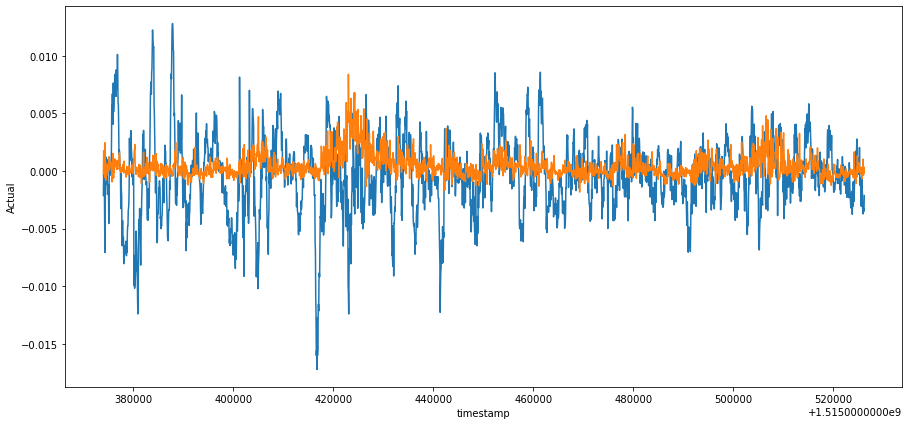

In [59]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=btc_pred_LR, x="timestamp", y="Actual")
sns.lineplot(data=btc_pred_LR, x="timestamp", y="Predicted")

In [60]:
LR_btc_importance = LR_btc.coef_

In [61]:
print("Веса линейной регрессии", end="\n\n")
for index, name in enumerate(X_btc_train.columns):
    print(f"Фича {name} имеет вес {round(LR_btc_importance[index], 4)}")
print(f"Свободный коэффициент равен: {round(LR_btc.intercept_, 4)}")

Веса линейной регрессии

Фича Open имеет вес -0.0308
Фича High имеет вес -0.0095
Фича Low имеет вес -0.0057
Фича Close имеет вес 0.0223
Фича Volume имеет вес 0.0005
Фича VWAP имеет вес 0.0234
Свободный коэффициент равен: 0.0001


* ### Decision Tree Regression

In [62]:
DT = DecisionTreeRegressor()

In [63]:
DT.fit(X_btc_train, y_btc_train)

DecisionTreeRegressor()

In [64]:
DT_btc_pred = DT.predict(X_btc_valid)

In [65]:
DT_btc_pred

array([ 0.00044163,  0.00846644,  0.00053856, ...,  0.00410966,
        0.00410966, -0.00533848])

In [66]:
btc_pred_DT = pd.DataFrame({
    "timestamp": btc["timestamp"][int(btc.shape[0] * 0.8):],
    "Actual": y_btc_valid, 
    "Predicted": DT_btc_pred})

In [67]:
btc_pred_DT

,timestamp,Actual,Predicted
79884,1515373980,-0.002128,0.000442
79892,1515374040,-0.000297,0.008466
79900,1515374100,-0.001767,0.000539
79908,1515374160,0.000042,-0.000203
79916,1515374220,-0.003806,0.000539
...,...,...,...
99965,1515525960,-0.003728,0.004337
99973,1515526020,-0.003222,-0.003412
99981,1515526080,-0.003520,0.004110
99988,1515526140,-0.003498,0.004110


<AxesSubplot:xlabel='timestamp', ylabel='Actual'>

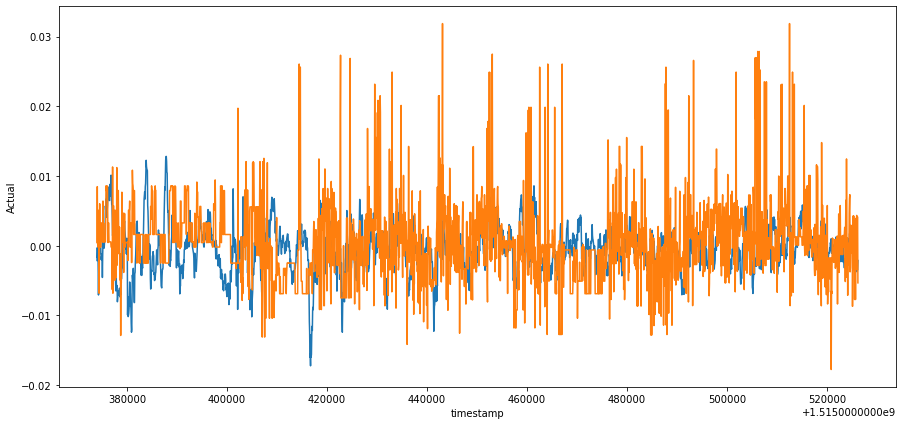

In [68]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=btc_pred_DT, x="timestamp", y="Actual")
sns.lineplot(data=btc_pred_DT, x="timestamp", y="Predicted")

In [69]:
parametrs = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 15],
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "max_features": ["auto", "sqrt", "log2"]
}

In [70]:
DT_1 = GridSearchCV(DT, param_grid=parametrs, n_jobs=-1)

In [71]:
DT_1.fit(X_btc_train, y_btc_train)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [72]:
DT_1.best_params_

{'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'sqrt'}

In [73]:
DT_1 = DT_1.best_estimator_

In [74]:
DT_1_btc_pred = DT_1.predict(X_btc_valid)

In [75]:
btc_pred_DT_1 = pd.DataFrame({
    "timestamp": btc["timestamp"][int(btc.shape[0] * 0.8):],
    "Actual": y_btc_valid, 
    "Predicted": DT_1_btc_pred})

In [76]:
btc_pred_DT_1

,timestamp,Actual,Predicted
79884,1515373980,-0.002128,-0.000576
79892,1515374040,-0.000297,-0.000576
79900,1515374100,-0.001767,-0.000576
79908,1515374160,0.000042,-0.000576
79916,1515374220,-0.003806,-0.000576
...,...,...,...
99965,1515525960,-0.003728,0.000679
99973,1515526020,-0.003222,0.000679
99981,1515526080,-0.003520,0.000679
99988,1515526140,-0.003498,0.000679


<AxesSubplot:xlabel='timestamp', ylabel='Actual'>

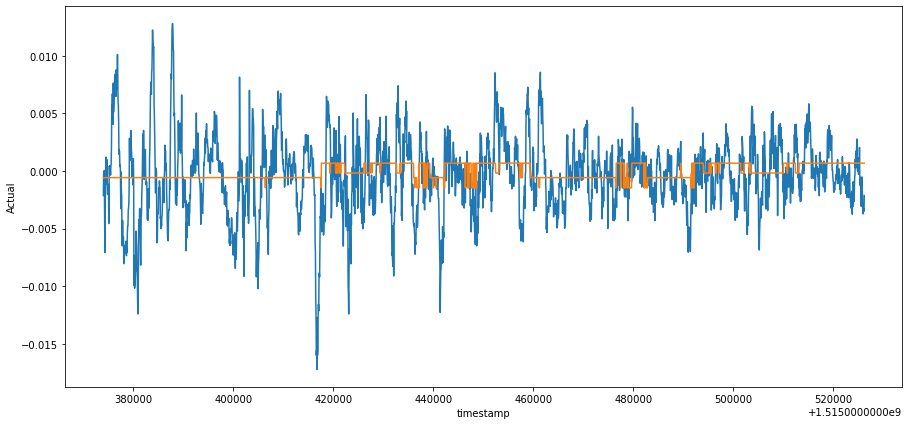

In [77]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=btc_pred_DT_1, x="timestamp", y="Actual")
sns.lineplot(data=btc_pred_DT_1, x="timestamp", y="Predicted")

* ### Random Forest Regression

In [78]:
RF = RandomForestRegressor()

In [79]:
RF.fit(X_btc_train, y_btc_train)

RandomForestRegressor()

In [80]:
RF_btc_pred = RF.predict(X_btc_valid)

In [81]:
RF_btc_pred

array([ 4.75255883e-03,  3.63607016e-03,  3.54979499e-03, ...,
       -5.97148697e-06, -1.17249192e-04,  4.47685792e-04])

In [82]:
btc_pred_RF = pd.DataFrame({
    "timestamp": btc["timestamp"][int(btc.shape[0] * 0.8):],
    "Actual": y_btc_valid, 
    "Predicted": RF_btc_pred})

In [83]:
btc_pred_RF

,timestamp,Actual,Predicted
79884,1515373980,-0.002128,0.004753
79892,1515374040,-0.000297,0.003636
79900,1515374100,-0.001767,0.003550
79908,1515374160,0.000042,0.004227
79916,1515374220,-0.003806,0.002228
...,...,...,...
99965,1515525960,-0.003728,0.002229
99973,1515526020,-0.003222,-0.000045
99981,1515526080,-0.003520,-0.000006
99988,1515526140,-0.003498,-0.000117


<AxesSubplot:xlabel='timestamp', ylabel='Actual'>

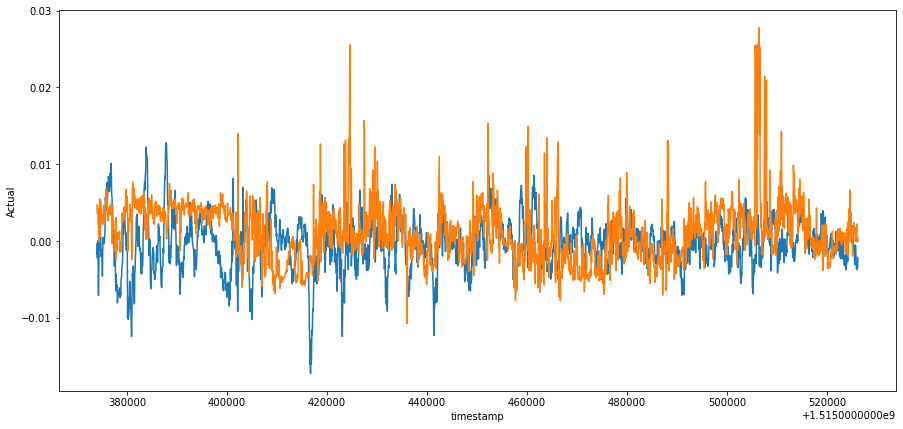

In [84]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=btc_pred_RF, x="timestamp", y="Actual")
sns.lineplot(data=btc_pred_RF, x="timestamp", y="Predicted")

In [85]:
parametrs = {
    "n_estimators": range(10, 101, 10),
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 15],
    "criterion": ["squared_error", "absolute_error"],
    "max_features": ["auto", "sqrt", "log2"]
}

In [86]:
grid_RF = GridSearchCV(RF, param_grid=parametrs)

In [87]:
grid_RF.fit(X_btc_train, y_btc_train)

KeyboardInterrupt: 

In [ ]:
grid_RF.best_params_

In [ ]:
RF_1 = grid_RF.best_estimator_

In [ ]:
RF_1_btc_pred = RF_1.predict(X_btc_valid)

In [ ]:
RF_1_btc_pred

In [ ]:
btc_pred_RF_1 = pd.DataFrame({
    "timestamp": btc["timestamp"][int(btc.shape[0] * 0.8):],
    "Actual": y_btc_valid, 
    "Predicted": RF_1_btc_pred})

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=btc_pred_RF_1, x="timestamp", y="Actual")
sns.lineplot(data=btc_pred_RF_1, x="timestamp", y="Predicted")

## Part 5: Function for Machine Learning

In [88]:
features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns

In [89]:
def ml_crypto(name):
    #подготовка данных
    crypto = df_without_null[df_without_null["Name"] == name]
    features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns
    sc = StandardScaler()
    crypto_scaled = sc.fit_transform(crypto.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))
    crypto_scaled = pd.DataFrame(crypto_scaled, columns=features)
    crypto_scaled["Target"] = list(crypto["Target"])
    X = crypto_scaled.drop("Target", axis=1)
    y = crypto["Target"]
    X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(X.shape[0] * 0.8)]
    X_valid, y_valid = X[int(X.shape[0] * 0.8):], y[int(X.shape[0] * 0.8):]
    y_train, y_valid = y_train * 1000, y_valid * 1000
    
    #линейная регрессия
    """
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_mae = round(mean_absolute_error(y_valid, lr.predict(X_valid)), 7)
    """
    #случайный лес
    """
    rf = RandomForestRegressor(criterion="absolute_error")
    parametrs = {
        "n_estimators": range(50, 101, 50),
        "max_depth": range(3, 12, 2),
        "max_features": ["sqrt", "log2"]
    }
    grid = GridSearchCV(rf, param_grid=parametrs, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Лучший параметры для Random Forest: {grid.best_params_}")
    grid_best = grid.best_estimator_    
    grid_mae = round(mean_absolute_error(y_valid, grid_best.predict(X_valid)), 7)
    """
    #гаус
    """
    kernel = 1.0 * RBF(length_scale=1.0)
    gpc = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gpc.fit(X_train, y_train)
    gpc_mae = round(mean_absolute_error(y_valid, gpc.predict(X_valid)), 7)    
    """
    
    #полином
    """
    pol = PolynomialFeatures(degree=2)
    X_train_pol = pol.fit_transform(X_train)
    X_valid_pol = pol.transform(X_valid)
    lr_pol = LinearRegression()
    lr_pol.fit(X_train_pol, y_train)
    pol_mae = round(mean_absolute_error(y_valid, lr_pol.predict(X_valid_pol)), 7)
    """
    #SVR
    """
    svr = SVR(kernel="linear")
    params_svr = {
        "kernel": ["linear", "poly", "rbf"],
        "gamma": ["scale", "auto"]
    }
    #grid_svr = GridSearchCV(svr, param_grid=params_svr, n_jobs=-1)
    #grid_svr.fit(X_train, y_train)
    svr.fit(X_train, y_train)
    #print(grid_svr.best_params_)
    #svr = grid_svr.best_estimator_
    svr_mae = round(mean_absolute_error(y_valid, svr.predict(X_valid)), 7)    
    """
    #xgboost
    xgb = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
    xgb.fit(X_train, y_train)
    xgb_mae = round(mean_absolute_error(y_valid, xgb.predict(X_valid)), 7)    
    
    #график
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=y_valid)
    #sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=lr.predict(X_valid))
    #sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=grid_best.predict(X_valid))
    #sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=gpc.predict(X_valid))
    #sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=lr_pol.predict(X_valid_pol))
    #sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=svr.predict(X_valid))
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=xgb.predict(X_valid))
    plt.title(f"График предсказания стоимости криптовалыты: {name}")
    plt.ylabel("Стоимость")
    plt.legend(["Actual", "XGB predicted"])
    #оценка метрики
    #print(f"Для криптовалюты {name} MAE на линейной регрессии: {lr_mae}")
    #print(f"Для криптовалюты {name} MAE на random forest: {grid_mae}")
    #print(f"Для криптовалюты {name} MAE на Гаусе: {gpc_mae}")
    #print(f"Для криптовалюты {name} MAE на полиномиальной регрессии: {pol_mae}")
    #print(f"Для криптовалюты {name} MAE на SVR: {svr_mae}")
    print(f"Для криптовалюты {name} MAE на XGBoost: {xgb_mae}")
    print()

In [90]:
def train_xgboost(name):
    #подготовка данных
    crypto = df_without_null[df_without_null["Name"] == name]
    features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns
    sc = StandardScaler()
    crypto_scaled = sc.fit_transform(crypto.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))
    crypto_scaled = pd.DataFrame(crypto_scaled, columns=features)
    crypto_scaled["Target"] = list(crypto["Target"])
    X = crypto_scaled.drop("Target", axis=1)
    y = crypto["Target"]
    X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(X.shape[0] * 0.8)]
    X_valid, y_valid = X[int(X.shape[0] * 0.8):], y[int(X.shape[0] * 0.8):]
    y_train, y_valid = y_train * 1000, y_valid * 1000
    #xgboost
    params = {
        "n_estimators": range(50, 201, 50),
        "max_depth": range(3, 10, 2)
    }
    #xgb = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
    grid = GridSearchCV(XGBRegressor(), param_grid=params, n_jobs=-1)
    #xgb.fit(X_train, y_train)
    grid.fit(X_train, y_train)
    xgb = grid.best_estimator_
    print(grid.best_params_)
    xgb_mae = round(mean_absolute_error(y_valid, xgb.predict(X_valid)), 7)    
    #график
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=y_valid)
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=xgb.predict(X_valid))
    plt.title(f"График предсказания стоимости криптовалыты: {name}")
    plt.ylabel("Стоимость")
    plt.legend(["Actual", "XGB predicted"])
    print(f"Для криптовалюты {name} MAE на XGBoost: {xgb_mae}")
    print()

In [91]:
def train_svr(name):
    #подготовка данных
    crypto = df_without_null[df_without_null["Name"] == name]
    features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns
    sc = StandardScaler()
    crypto_scaled = sc.fit_transform(crypto.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))
    crypto_scaled = pd.DataFrame(crypto_scaled, columns=features)
    crypto_scaled["Target"] = list(crypto["Target"])
    X = crypto_scaled.drop("Target", axis=1)
    y = crypto["Target"]
    X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(X.shape[0] * 0.8)]
    X_valid, y_valid = X[int(X.shape[0] * 0.8):], y[int(X.shape[0] * 0.8):]
    y_train, y_valid = y_train * 1000, y_valid * 1000
    #SVR
    svr = SVR()
    params_svr = {
        "kernel": ["linear", "poly", "rbf"],
        "gamma": ["scale", "auto"],
        "C": np.arange(0.5, 2.6, 0.5)
    }
    grid_svr = GridSearchCV(svr, param_grid=params_svr, n_jobs=-1)
    grid_svr.fit(X_train, y_train)
    best_svr = grid_svr.best_estimator_
    best_svr.fit(X_train, y_train)
    print(grid_svr.best_params_)
    svr_mae = round(mean_absolute_error(y_valid, best_svr.predict(X_valid)), 7)    
    #график
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=y_valid)
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=best_svr.predict(X_valid))
    plt.title(f"График предсказания стоимости криптовалыты: {name}")
    plt.ylabel("Стоимость")
    plt.legend(["Actual", "SVR predicted"])
    #оценка метрики
    print(f"Для криптовалюты {name} MAE на SVR: {svr_mae}")
    print()

In [92]:
def train_polynom(name):
    #подготовка данных
    crypto = df_without_null[df_without_null["Name"] == name]
    features = df_without_null.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1).columns
    sc = StandardScaler()
    crypto_scaled = sc.fit_transform(crypto.drop(["timestamp", "Asset_ID", "Count", "Name", "Target"], axis=1))
    crypto_scaled = pd.DataFrame(crypto_scaled, columns=features)
    crypto_scaled["Target"] = list(crypto["Target"])
    X = crypto_scaled.drop("Target", axis=1)
    y = crypto["Target"]
    X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(X.shape[0] * 0.8)]
    X_valid, y_valid = X[int(X.shape[0] * 0.8):], y[int(X.shape[0] * 0.8):]
    #y_train, y_valid = y_train * 1000, y_valid * 1000
    #полином
    pol = PolynomialFeatures(degree=2)
    X_train_pol = pol.fit_transform(X_train)
    X_valid_pol = pol.transform(X_valid)
    lr_pol = LinearRegression()
    lr_pol.fit(X_train_pol, y_train)
    pol_mae = round(mean_absolute_error(y_valid, lr_pol.predict(X_valid_pol)), 7)
    #график
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=y_valid)
    sns.lineplot(x=crypto["timestamp"][int(X.shape[0] * 0.8):], y=lr_pol.predict(X_valid_pol))
    plt.title(f"График предсказания стоимости криптовалыты: {name}")
    plt.ylabel("Стоимость")
    plt.legend(["Actual", "Polynom predicted"])
    #оценка метрики
    print(f"Для криптовалюты {name} MAE на Polynom: {pol_mae}")
    print()

In [ ]:
%%time
train_svr("Bitcoin")

In [ ]:
%%time
train_polynom("Bitcoin")

In [ ]:
%%time
train_svr("Bitcoin")

In [ ]:
%%time
train_svr("Bitcoin")

In [ ]:
%%time
train_svr("Bitcoin Cash")

In [ ]:
%%time
train_svr("Binance Coin")

In [ ]:
%%time
train_svr("EOS.IO")

In [ ]:
%%time
train_svr("Ethereum Classic")

{'C': 0.5, 'gamma': 'auto', 'kernel': 'poly'}
Для криптовалюты Ethereum MAE на SVR: 4.925248

CPU times: user 9.34 s, sys: 161 ms, total: 9.5 s
Wall time: 3min 50s


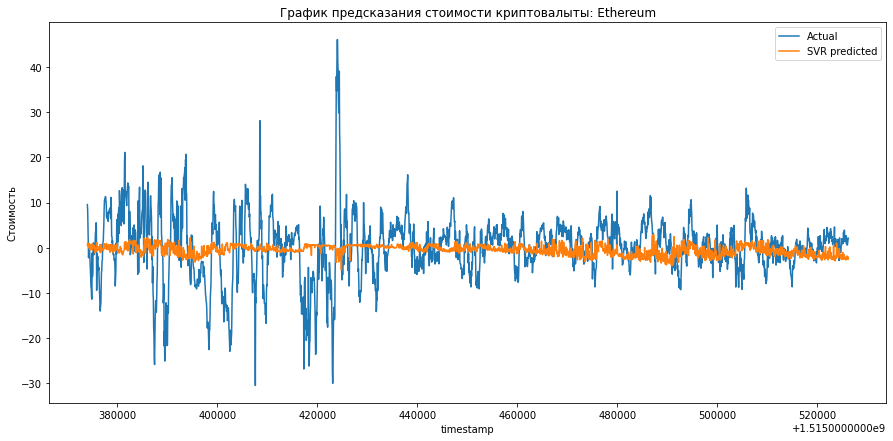

In [93]:
%%time
train_svr("Ethereum")

In [ ]:
%%time
train_svr("Litecoin")

In [ ]:
%%time
train_svr("Monero")